# Homework assignment №5

# Music Generation (with Mamba)

In [1]:
import time
import pickle
import csv

import torch
from tqdm import tqdm
from mambapy.lm import MambaConfig
from mambapy.lm import LM as MambaLM
from torch.optim.lr_scheduler import CosineAnnealingLR
import torch.nn.functional as F

from mido import Message, MidiFile, MidiTrack
from midi2audio import FluidSynth
from IPython.display import Audio


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
match device.type:
    case "cuda":
        print(f"Device: {torch.cuda.get_device_name()}")
    case "cpu":
        print("Device: CPU")

Device: NVIDIA GeForce RTX 4060


# Prepare the data

`chopin-notes` is a custom dataset that I collected a year ago for a side project.

In [2]:
with open("../data/chopin-notes", "rb") as f:
    notes: list[str] = pickle.load(f)

unique_notes = list(set(notes))
vocab_size = len(unique_notes)
print("Vocab size:", vocab_size)
note_to_idx = {note: i for i, note in enumerate(unique_notes)}
idx_to_note = {i: note for note, i in note_to_idx.items()}

Vocab size: 4289


In [3]:
class DataLoader:
    def __init__(self, B: int, L: int):
        """
        Dataloader to parse data in a format needed to train Large Language models.
        """
        self.B = B
        self.L = L

        ids = list(map(note_to_idx.get, notes))
        ids = torch.Tensor(ids).type(torch.long)

        self.tokens = ids
        self.current_position = 0

    def next_batch(self):
        B, L = self.B, self.L
        buf = self.tokens[self.current_position : self.current_position + B * L + 1]
        inputs = (buf[:-1]).view(B, L)
        targets = (buf[1:]).view(B, L)
        self.current_position += B * L

        if self.current_position + B * L < len(self.tokens):
            self.current_position = 0
        return inputs, targets

# Set up and train a model

In [4]:
BATCH_SIZE: int = 32
CONTEXT_WINDOW: int = 512

dataloader = DataLoader(B=BATCH_SIZE, L=CONTEXT_WINDOW)
config = MambaConfig(d_model=BATCH_SIZE, n_layers=4)
model = MambaLM(config, vocab_size=vocab_size)

model.train()
model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, betas=(0.9, 0.95), eps=1e-8, fused=True)
scheduler = CosineAnnealingLR(optimizer=optimizer, eta_min=1e-4, T_max=1000)

with open("training_logs.csv", mode="w", newline="", encoding="utf8") as file:
    writer = csv.writer(file)
    writer.writerow(["Step", "Loss", "Norm", "LR", "dt (ms)", "Tokens/sec"])

for step in tqdm(range(0, 301)):
    model.train()
    t0 = time.time()

    optimizer.zero_grad()

    inputs, targets = dataloader.next_batch()
    inputs, targets = inputs.to(device), targets.to(device)

    with torch.autocast(device_type="cuda", dtype=torch.bfloat16):
        outputs = model(inputs)

    loss = F.cross_entropy(outputs.view(-1, outputs.size(-1)), targets.view(-1))
    loss.backward()
    norm = torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    optimizer.step()
    scheduler.step()

    torch.cuda.synchronize()
    t1 = time.time()
    dt = t1 - t0
    tokens_processed =  dataloader.B * dataloader.L
    tokens_per_sec = tokens_processed / dt
    with open("training_logs.csv", mode="a", newline="", encoding="utf8") as file:
        writer = csv.writer(file)
        writer.writerow([step, f"{loss.item():.6f}", f"{norm:.4f}", f"{scheduler.get_last_lr()[0]:.4e}", f"{dt * 1000:.2f}", f"{tokens_per_sec:.2f}"])

torch.save(model.state_dict(), f"mamba_cp_{step}.pth")

100%|██████████| 301/301 [00:36<00:00,  8.30it/s]


### Let's generate a song using the last `context_window` notes from the dataset
(the last sequence is used, because the model doesn't know how it continues)

In [5]:
def generate_text(model, notes_to_generate: int = 32, prompt: list[str] = ""):
    model.eval()
    ids = list(map(note_to_idx.get, prompt))
    ids = torch.Tensor(ids).type(torch.long).to(device).unsqueeze(0)
    generated_tokens = []

    for _ in range(notes_to_generate):
        with torch.no_grad(), torch.autocast(device_type="cuda", dtype=torch.bfloat16):
            logits = model(ids)[:, -1, :]
        next_token = torch.multinomial(F.softmax(logits, dim=-1), 1)
        generated_tokens.append(next_token.item())
        prompt = torch.cat((ids[:, 1:], torch.multinomial(F.softmax(logits, dim=-1), 1)), dim=1)

    return list(map(idx_to_note.get, generated_tokens))

generated_song = generate_text(model=model, notes_to_generate=512, prompt=notes[-CONTEXT_WINDOW:])

### Convert the generated notes (`str` objects) to the `.mid` format

In [6]:
NOTE_MAPPING = {
    'C': 0, 'C#': 1, 'D': 2, 'D#': 3, 'E': 4, 'F': 5,
    'F#': 6, 'G': 7, 'G#': 8, 'A': 9, 'A#': 10, 'B': 11
}

def note_to_midi(note):
    if note[-1].isdigit():
        pitch, octave = note[:-1], int(note[-1])
        return (octave + 1) * 12 + NOTE_MAPPING[pitch]
    return None

midi = MidiFile()
track = MidiTrack()
midi.tracks.append(track)
tempo = 120  # BPM
tick_duration = midi.ticks_per_beat // 4  # 16th note

for note_group in generated_song:
    note_list = note_group.split('.')
    midi_numbers = [note_to_midi(note) for note in note_list if note_to_midi(note) is not None]
    for midi_num in midi_numbers:
        track.append(Message('note_on', note=midi_num, velocity=64, time=0))
    for midi_num in midi_numbers:
        track.append(Message('note_off', note=midi_num, velocity=64, time=tick_duration))

midi_path = "generated_song.mid"
midi.save(midi_path)

### The file was converted to `.mp3` and attached to this repo.

### Listen to it -> `hw05/README.md`

# Conclusions

1. Training process was stable and smooth (not a single loss spike!)
2. The generated songs show good diversity, avoiding simple melody repetition
3. The model avoided local minima problems that were common in (x)LSTM models
4. The model learned musical patterns and chord progressions from the training data

# Overall conclusion:
**The model architecture effectively captures both local and global musical structures for music generation**


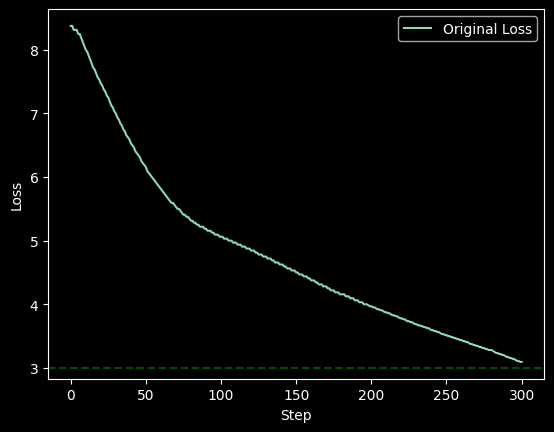

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv("training_logs.csv")
plt.plot(data["Step"], data["Loss"], label="Original Loss")
plt.axhline(y=3, color='g', linestyle='--', alpha=0.6)
plt.xlabel("Step")
plt.ylabel("Loss")
plt.legend()
plt.show()